# Custom statespace models

The true power of the state space model is to allow the creation and estimation of custom models. This notebook shows various statespace models that subclass `sm.tsa.statespace.MLEModel`.

Remember the general state space model can be written in the following general way:

$$
\begin{aligned}
y_t & = Z_t \alpha_{t} + d_t +  \varepsilon_t \\
\alpha_{t+1} & = T_t \alpha_{t} + c_t + R_t \eta_{t}
\end{aligned}
$$

You can check the details and the dimensions of the objects [in this link](https://www.statsmodels.org/stable/statespace.html#custom-state-space-models)

Most models won't include all of these elements. For example, the design matrix $Z_t$ might not depend on time ($\forall t \;Z_t = Z$), or the model won't have an observation intercept $d_t$.

We'll start with something relatively simple and then show how to extend it bit by bit to include more elements.

+ Model 1: time-varying coefficients. One observation equation with two state equations
+ Model 2: time-varying parameters with non identity transition matrix
+ Model 3: multiple observation and multiple state equations
+ Bonus: pymc3 for bayesian estimation

In [40]:
%matplotlib inline

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from collections import OrderedDict

## Model 1: time-varying coefficients

$$
\begin{aligned}
y_t & = d + x_t \beta_{x,t} + w_t \beta_{w,t} + \varepsilon_t \hspace{4em} \varepsilon_t \sim N(0, \sigma_\varepsilon^2)\\
\begin{bmatrix} \beta_{x,t} \\ \beta_{w,t} \end{bmatrix} & = \begin{bmatrix} \beta_{x,t-1} \\ \beta_{w,t-1} \end{bmatrix} + \begin{bmatrix} \zeta_{x,t} \\ \zeta_{w,t} \end{bmatrix} \hspace{3.7em} \begin{bmatrix} \zeta_{x,t} \\ \zeta_{w,t} \end{bmatrix} \sim N \left ( \begin{bmatrix} 0 \\ 0 \end{bmatrix}, \begin{bmatrix} \sigma_{\beta, x}^2 & 0 \\ 0 & \sigma_{\beta, w}^2 \end{bmatrix} \right )
\end{aligned}
$$

The observed data is $y_t, x_t, w_t$. With $x_t, w_t$ being the exogenous variables. Notice that the desing matrix is time-varying, so it will have three dimensions (`k_endog x k_states x nobs`)

The states are $\beta_{x,t}$ and $\beta_{w,t}$. The state equation tells us these states evolve with a random walk. Thus, in this case the transition matrix is a 2 by 2 identity matrix.

We'll first simulate the data, the construct a model and finally estimate it.

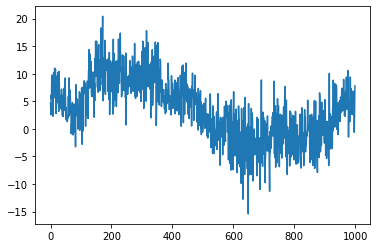

In [11]:
def gen_data_for_model1():
    nobs = 1000

    rs = np.random.RandomState(seed=93572)

    d = 5
    var_y = 5
    var_coeff_x = 0.01
    var_coeff_w = 0.5

    x_t = rs.uniform(size=nobs)
    w_t = rs.uniform(size=nobs)
    eps = rs.normal(scale=var_y**0.5, size=nobs)

    beta_x = np.cumsum(rs.normal(size=nobs, scale=var_coeff_x**0.5))
    beta_w = np.cumsum(rs.normal(size=nobs, scale=var_coeff_w**0.5))

    y_t = d + beta_x * x_t + beta_w * w_t + eps
    return y_t, x_t, w_t, beta_x, beta_w 

y_t, x_t, w_t, beta_x, beta_w = gen_data_for_model1()
plt.plot(y_t)



In [17]:
class TVRegression(sm.tsa.statespace.MLEModel):
    def __init__(self, y_t, x_t, w_t):
        exog = np.c_[x_t, w_t]  # shaped nobs x 2

        super(TVRegression, self).__init__(
            endog=y_t, exog=exog, k_states=2,
            initialization='diffuse')

        # Since the design matrix is time-varying, it must be
        # shaped k_endog x k_states x nobs
        # Notice that exog.T is shaped k_states x nobs, so we
        # just need to add a new first axis with shape 1
        self.ssm['design'] = exog.T[np.newaxis, :, :]  # shaped 1 x 2 x nobs
        self.ssm['selection'] = np.eye(self.k_states)
        self.ssm['transition'] = np.eye(self.k_states)
        
        #Which parameters need to be positive?
        self.positive_parameters = slice(1, 4)

    @property
    def param_names(self):
        return ['intercept', 'var.e', 'var.x.coeff', 'var.w.coeff']

    @property
    def start_params(self):
        """
        Defines the starting values for the parameters
        The linear regression gives us reasonable starting values for the constant
        d and the variance of the epsilon error
        """
        exog = sm.add_constant(self.exog)
        res = sm.OLS(self.endog, exog).fit()
        params = np.r_[res.params[0], res.scale, 0.001, 0.001]
        return params

    def transform_params(self, unconstrained):
        """
        We constraint the last three parameters
        ('var.e', 'var.x.coeff', 'var.w.coeff') to be positive, 
        because they are variances
        """
        constrained = unconstrained.copy()
        constrained[self.positive_parameters] = constrained[self.positive_parameters]**2
        return constrained

    def untransform_params(self, constrained):
        """
        Need to unstransform all the parameters you transformed
        in the `transform_params` function
        """
        unconstrained = constrained.copy()
        unconstrained[self.positive_parameters] = unconstrained[self.positive_parameters]**0.5
        return unconstrained

    def update(self, params, **kwargs):
        params = super(TVRegression, self).update(params, **kwargs)

        self['obs_intercept', 0, 0] = params[0]
        self['obs_cov', 0, 0] = params[1]
        self['state_cov'] = np.diag(params[2:4])

#### And then estimate it with our custom model class

In [18]:
mod = TVRegression(y_t, x_t, w_t)
res = mod.fit()

print(res.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                 1000
Model:                   TVRegression   Log Likelihood               -2336.846
Date:                Thu, 30 Apr 2020   AIC                           4685.692
Time:                        19:17:00   BIC                           4715.139
Sample:                             0   HQIC                          4696.884
                               - 1000                                         
Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept       5.0548      0.202     25.050      0.000       4.659       5.450
var.e           5.1240      0.249     20.571      0.000       4.636       5.612
var.x.coeff     0.0468      0.022      2.097    

The values that generated the data were:

+ intercept = 5
+ var.e = 5
+ var.x.coeff = 0.01
+ var.w.coeff = 0.5


As you can see, the estimation recovered the real parameters pretty well.

We can also recover the estimated evolution of the underlying coefficients (or states in Kalman filter talk)

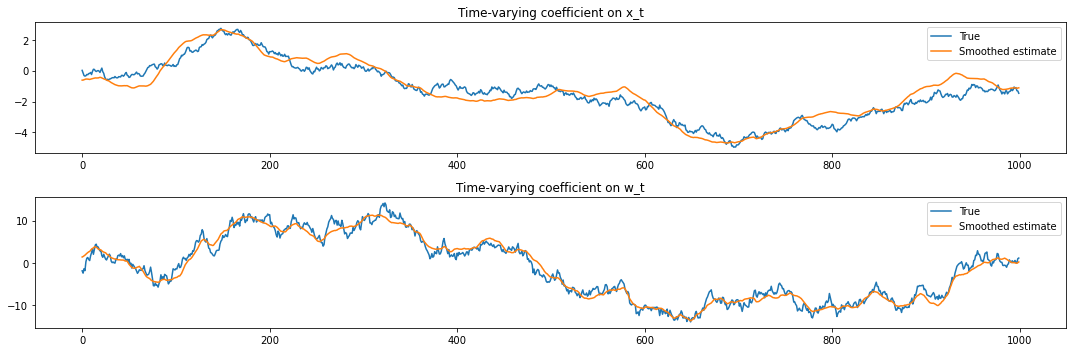

In [12]:
fig, axes = plt.subplots(2, figsize=(15, 5))

ss = pd.DataFrame(res.smoothed_state.T, columns=['x', 'w'])

axes[0].plot(beta_x, label='True')
axes[0].plot(ss['x'], label='Smoothed estimate')
axes[0].set(title='Time-varying coefficient on x_t')
axes[0].legend()

axes[1].plot(beta_w, label='True')
axes[1].plot(ss['w'], label='Smoothed estimate')
axes[1].set(title='Time-varying coefficient on w_t')
axes[1].legend()

fig.tight_layout();

## Model 2: time-varying parameters with non identity transition matrix

explain how it's an extension


$$
\begin{aligned}
y_t & = d + x_t \beta_{x,t} + w_t \beta_{w,t} + \varepsilon_t \hspace{4em} \varepsilon_t \sim N(0, \sigma_\varepsilon^2)\\
\begin{bmatrix} \beta_{x,t} \\ \beta_{w,t} \end{bmatrix} & = \begin{bmatrix} \rho_1 & 0 \\ 0 & \rho_2 \end{bmatrix} \begin{bmatrix} \beta_{x,t-1} \\ \beta_{w,t-1} \end{bmatrix} + \begin{bmatrix} \zeta_{x,t} \\ \zeta_{w,t} \end{bmatrix} \hspace{3.7em} \begin{bmatrix} \zeta_{x,t} \\ \zeta_{w,t} \end{bmatrix} \sim N \left ( \begin{bmatrix} 0 \\ 0 \end{bmatrix}, \begin{bmatrix} \sigma_{\beta, x}^2 & 0 \\ 0 & \sigma_{\beta, w}^2 \end{bmatrix} \right )
\end{aligned}
$$


We've added two new parameters: $\rho_1, \rho_2$

What should we modify in our previous class to make things work?
+ Good news: not a lot!
+ Bad news: we need to be careful about a few things

### 1) Change the starting parameters function

We need to add names for the new parameters $\rho_1, \rho_2$ and we need to start corresponding starting values.

The `param_names` function goes from:

```python
def param_names(self):
    return ['intercept', 'var.e', 'var.x.coeff', 'var.w.coeff']
```


to 

```python
def param_names(self):
    return ['intercept', 'var.e', 'var.x.coeff', 'var.w.coeff',
           'rho1', 'rho2']
```

and we change the `start_params` function from 

```python
def start_params(self):
    exog = sm.add_constant(self.exog)
    res = sm.OLS(self.endog, exog).fit()
    params = np.r_[res.params[0], res.scale, 0.001, 0.001]
    return params
```

to

```python
def start_params(self):
    exog = sm.add_constant(self.exog)
    res = sm.OLS(self.endog, exog).fit()
    params = np.r_[res.params[0], res.scale, 0.001, 0.001, 0.8, 0.8]
    return params
```

2) Change the `update` function

It goes from

```python
def update(self, params, **kwargs):
    params = super(TVRegression, self).update(params, **kwargs)

    self['obs_intercept', 0, 0] = params[0]
    self['obs_cov', 0, 0] = params[1]
    self['state_cov'] = np.diag(params[2:4])
```


to 

```python
def update(self, params, **kwargs):
    params = super(TVRegression, self).update(params, **kwargs)

    self['obs_intercept', 0, 0] = params[0]
    self['obs_cov', 0, 0] = params[1]
    self['state_cov'] = np.diag(params[2:4])
    self['transition', 0, 0] = params[4]
    self['transition', 1, 1] = params[5]
```


3) (optional) change `transform_params` and `untransform_params`

This is not required, but you might wanna restrict $\rho_1, \rho_2$ to lie between -1 and 1.
In that case, we first import two utility functions from `statsmodels`.


```python
from statsmodels.tsa.statespace.tools import (
    constrain_stationary_univariate, unconstrain_stationary_univariate)
```

`constrain_stationary_univariate` constraint the value to be within -1 and 1. 
`unconstrain_stationary_univariate` provides the inverse function.
The transform and untransform parameters function would look like this
(remember that $\rho_1, \rho_2$ are in the 4 and 5th index):

```python
def transform_params(self, unconstrained):
    constrained = unconstrained.copy()
    constrained[self.positive_parameters] = constrained[self.positive_parameters]**2
    constrained[4] = constrain_stationary_univariate(constrained[4:5])
    constrained[5] = constrain_stationary_univariate(constrained[5:6])
    return constrained

def untransform_params(self, constrained):
    unconstrained = constrained.copy()
    unconstrained[self.positive_parameters] = unconstrained[self.positive_parameters]**0.5
    unconstrained[4] = unconstrain_stationary_univariate(constrained[4:5])
    unconstrained[5] = unconstrain_stationary_univariate(constrained[5:6])
    return unconstrained
```

I'll write the full class below:

In [30]:
class TVRegressionExtended(sm.tsa.statespace.MLEModel):
    def __init__(self, y_t, x_t, w_t):
        exog = np.c_[x_t, w_t]  # shaped nobs x 2

        super(TVRegressionExtended, self).__init__(
            endog=y_t, exog=exog, k_states=2,
            initialization='diffuse')

        # Since the design matrix is time-varying, it must be
        # shaped k_endog x k_states x nobs
        # Notice that exog.T is shaped k_states x nobs, so we
        # just need to add a new first axis with shape 1
        self.ssm['design'] = exog.T[np.newaxis, :, :]  # shaped 1 x 2 x nobs
        self.ssm['selection'] = np.eye(self.k_states)
        self.ssm['transition'] = np.eye(self.k_states)
        
        #Which parameters need to be positive?
        self.positive_parameters = slice(1, 4)

    @property
    def param_names(self):
        return ['intercept', 'var.e', 'var.x.coeff', 'var.w.coeff',
                'rho1', 'rho2']

    @property
    def start_params(self):
        """
        Defines the starting values for the parameters
        The linear regression gives us reasonable starting values for the constant
        d and the variance of the epsilon error
        """

        exog = sm.add_constant(self.exog)
        res = sm.OLS(self.endog, exog).fit()
        params = np.r_[res.params[0], res.scale, 0.001, 0.001, 0.7, 0.8]
        return params

    def transform_params(self, unconstrained):
        """
        We constraint the last three parameters
        ('var.e', 'var.x.coeff', 'var.w.coeff') to be positive, 
        because they are variances
        """
        constrained = unconstrained.copy()
        constrained[self.positive_parameters] = constrained[self.positive_parameters]**2
        return constrained

    def untransform_params(self, constrained):
        """
        Need to unstransform all the parameters you transformed
        in the `transform_params` function
        """
        unconstrained = constrained.copy()
        unconstrained[self.positive_parameters] = unconstrained[self.positive_parameters]**0.5
        return unconstrained

    def update(self, params, **kwargs):
        params = super(TVRegressionExtended, self).update(params, **kwargs)

        self['obs_intercept', 0, 0] = params[0]
        self['obs_cov', 0, 0] = params[1]
        self['state_cov'] = np.diag(params[2:4])
        self['transition', 0, 0] = params[4]
        self['transition', 1, 1] = params[5]

To estimate, we'll use the same data as in model 1 and expect the $\rho_1, \rho_2$ to be near 1.

The results look pretty good!
Note that this estimation can be quite sensitive to the starting value of $\rho_1, \rho_2$. If you try lower values, you'll see it fails to converge.

In [32]:
mod = TVRegressionExtended(y_t, x_t, w_t)
res = mod.fit(maxiter=2000) #it doesn't converge with 50 iters
print(res.summary())

                            Statespace Model Results                            
Dep. Variable:                        y   No. Observations:                 1000
Model:             TVRegressionExtended   Log Likelihood               -2334.778
Date:                  Thu, 30 Apr 2020   AIC                           4685.557
Time:                          19:31:07   BIC                           4724.819
Sample:                               0   HQIC                          4700.479
                                 - 1000                                         
Covariance Type:                    opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept       5.0315      0.201     25.077      0.000       4.638       5.425
var.e           5.1000      0.249     20.460      0.000       4.611       5.589
var.x.coeff     0.0599      0.03

## Model 3: multiple observation and state equations

We'll keep the time-varying parameters, but this time we'll also have two observation equations.

### Observation equations

$\hat{i_t}, \hat{M_t},  \hat{s_t}$ are observed each period.

The model for the observation equation has two equations:

$$ \hat{i_t} = \alpha_1 * \hat{s_t} + \varepsilon_1 $$

$$ \hat{M_t} = \alpha_2 + \varepsilon_2 $$

Following the [general notation from state space models](https://www.statsmodels.org/stable/statespace.html), the endogenous part of the observation equation is $y_t = (\hat{i_t},  \hat{M_t})$ and we only have one exogenous variable $\hat{s_t}$


### State equations


$$ \alpha_{1, t+1} = \delta_1 \alpha_{1, t} + \delta_2 \alpha_{2, t} + W_1 $$

$$ \alpha_{2, t+1} = \delta_3  \alpha_{2, t} + W_2 $$


### Matrix notation for the state space model

$$
\begin{aligned}
\begin{bmatrix} \hat{i_t} \\ \hat{M_t} \end{bmatrix} &= 
\begin{bmatrix} \hat{s_t}  & 0 \\ 0 & 1 \end{bmatrix} \begin{bmatrix} \alpha_{1, t} \\ \alpha_{2, t} \end{bmatrix} + \begin{bmatrix} \varepsilon_{1, t} \\ \varepsilon_{1, t} \end{bmatrix}  \hspace{6.5em} \varepsilon_t \sim N \left ( \begin{bmatrix} 0 \\ 0 \end{bmatrix}, \begin{bmatrix} \sigma_{\varepsilon_1}^2 & 0 \\ 0 & \sigma_{\varepsilon_2}^2  \end{bmatrix} \right )
\\
\begin{bmatrix} \alpha_{1, t+1} \\ \alpha_{2, t+1} \end{bmatrix} & = \begin{bmatrix} \delta_1 & \delta_1 \\ 0 & \delta_3 \end{bmatrix} \begin{bmatrix} \alpha_{1, t} \\ \alpha_{2, t} \end{bmatrix} + \begin{bmatrix} W_1 \\ W_2 \end{bmatrix} \hspace{3.em} \begin{bmatrix} W_1 \\ W_2 \end{bmatrix} \sim N \left ( \begin{bmatrix} 0 \\ 0 \end{bmatrix}, \begin{bmatrix} \sigma_{W_1}^2 & 0 \\ 0 & \sigma_{W_2}^2 \end{bmatrix} \right )
\end{aligned}
$$

I'll simulate some data, talk about what we need to modify and finally estimate the model to see if we're recovering something reasonable.


In [37]:
true_values = {'var_e1': 0.01, 'var_e2': 0.01,
               'var_w1': 0.01, 'var_w2': 0.01,
               'delta1': 0.8, 'delta2': 0.5, 'delta3': 0.7}

def gen_data_for_model3():
    #Starting values
    alpha1_0 = 2.1
    alpha2_0 = 1.1

    t_max = 500

    def gen_i(alpha1, s):
        return alpha1*s + np.sqrt(true_values['var_e1'])*np.random.randn()

    def gen_m_hat(alpha2):
        return 1*alpha2 + np.sqrt(true_values['var_e2'])*np.random.randn()

    def gen_alpha1(alpha1, alpha2):
        w1 = np.sqrt(true_values['var_w1'])*np.random.randn()
        return true_values['delta1'] * alpha1 + true_values['delta2'] * alpha2 + w1

    def gen_alpha2(alpha2):
        w2 = np.sqrt(true_values['var_w2'])*np.random.randn()
        return true_values['delta3'] * alpha2 + w2

    s_t = 0.3 + np.sqrt(1.4)*np.random.randn(t_max)
    i_hat = np.empty(t_max)
    m_hat = np.empty(t_max)

    current_alpha1 = alpha1_0
    current_alpha2 = alpha2_0
    for t in range(t_max):
        #Obs eqns
        i_hat[t] = gen_i(current_alpha1, s_t[t])
        m_hat[t] = gen_m_hat(current_alpha2)

        #state eqns
        new_alpha1 = gen_alpha1(current_alpha1, current_alpha2)
        new_alpha2 = gen_alpha2(current_alpha2)

        #Update states for next period
        current_alpha1 = new_alpha1
        current_alpha2 = new_alpha2
        
    return i_hat, m_hat, s_t

i_hat, m_hat, s_t = gen_data_for_model3()

### What do we need to modify?

Once again, we don't need to change much, but we need to be careful about the dimensions.

#### 1) The `__init__` function changes from


```python
def __init__(self, y_t, x_t, w_t):
        exog = np.c_[x_t, w_t]

        super(TVRegressionExtended, self).__init__(
            endog=y_t, exog=exog, k_states=2,
            initialization='diffuse')

        self.ssm['design'] = exog.T[np.newaxis, :, :]  # shaped 1 x 2 x nobs
        self.ssm['selection'] = np.eye(self.k_states)
        self.ssm['transition'] = np.eye(self.k_states)
```

to


```python
def __init__(self, i_t: np.array, s_t: np.array, m_t: np.array):

        exog = np.c_[s_t, np.repeat(1, len(s_t))]  # exog.shape => (nobs, 2)
        
        super(MultipleYsModel, self).__init__(
            endog=np.c_[i_t, m_t], exog=exog, k_states=2,
            initialization='diffuse')
        
        self.ssm['design'] = np.zeros((self.k_endog, self.k_states, self.nobs))
        self.ssm['design', 0, 0, :] = s_t
        self.ssm['design', 1, 1, :] = 1
```

Note that we didn't have to specify `k_endog` anywhere. The initialization does this for us after checking the dimensions of the `exog` matrix.


#### 2) The `update()` function 

changes from 

```python
def update(self, params, **kwargs):
    params = super(TVRegressionExtended, self).update(params, **kwargs)

    self['obs_intercept', 0, 0] = params[0]
    self['obs_cov', 0, 0] = params[1]
    
    self['state_cov'] = np.diag(params[2:4])
    self['transition', 0, 0] = params[4]
    self['transition', 1, 1] = params[5]
```


to


```python
def update(self, params, **kwargs):
    params = super(MultipleYsModel, self).update(params, **kwargs)
    
    
    #The following line is not needed (by default, this matrix is initialized by zeroes),
    #But I leave it here so the dimensions are clearer
    self['obs_intercept'] = np.repeat([np.array([0, 0])], self.nobs, axis=0).T
    self['obs_cov', 0, 0] = params[0]
    self['obs_cov', 1, 1] = params[1]

    self['state_cov'] = np.diag(params[2:4])
    #delta1, delta2, delta3
    self['transition', 0, 0] = params[4]
    self['transition', 0, 1] = params[5]
    self['transition', 1, 1] = params[6]
```

The rest of the methods change in pretty obvious ways (need to add parameter names, make sure the indexes work, etc). The full code for the function is right below

In [49]:
starting_values = {'var_e1': 0.2, 'var_e2': 0.1,
                   'var_w1': 0.15, 'var_w2': 0.18,
                    'delta1': 0.7, 'delta2': 0.1, 'delta3': 0.85}


class MultipleYsModel(sm.tsa.statespace.MLEModel):
    def __init__(self, i_t: np.array, s_t: np.array, m_t: np.array):

        exog = np.c_[s_t, np.repeat(1, len(s_t))]  # exog.shape => (nobs, 2)
        
        super(MultipleYsModel, self).__init__(
            endog=np.c_[i_t, m_t], exog=exog, k_states=2,
            initialization='diffuse')
        
        self.ssm['design'] = np.zeros((self.k_endog, self.k_states, self.nobs))
        self.ssm['design', 0, 0, :] = s_t
        self.ssm['design', 1, 1, :] = 1
        
        #These have ok shape. Placeholders since I'm changing them
        #in the update() function
        self.ssm['selection'] = np.eye(self.k_states)
        self.ssm['transition'] = np.eye(self.k_states)
        
        #Dictionary of positions to names
        self.position_dict = OrderedDict(var_e1=1, var_e2=2, 
                         var_w1=3, var_w2=4,
                         delta1=5, delta2=6, delta3=7)
        self.initial_values = starting_values
        self.positive_parameters = slice(0, 4)
        

    @property
    def param_names(self):
        return list(self.position_dict.keys())

    @property
    def start_params(self):
        """
        Initial values
        """
        #(optional) Use scale for var_e1 and var_e2 starting values
        params = np.r_[self.initial_values['var_e1'],
                       self.initial_values['var_e2'],
                       self.initial_values['var_w1'],
                       self.initial_values['var_w2'],
                       self.initial_values['delta1'],
                       self.initial_values['delta2'],
                       self.initial_values['delta3']]
        return params

    def transform_params(self, unconstrained):
        """
        If you need to restrict parameters
        For example, variances should be > 0
        Parameters maybe have to be within -1 and 1
        """
        constrained = unconstrained.copy()
        constrained[self.positive_parameters] = constrained[self.positive_parameters]**2
        return constrained

    def untransform_params(self, constrained):
        """
        Need to reverse what you did in transform_params()
        """
        unconstrained = constrained.copy()
        unconstrained[self.positive_parameters] = unconstrained[self.positive_parameters]**0.5
        return unconstrained

    def update(self, params, **kwargs):
        params = super(MultipleYsModel, self).update(params, **kwargs)
        
        #The following line is not needed (by default, this matrix is initialized by zeroes),
        #But I leave it here so the dimensions are clearer
        self['obs_intercept'] = np.repeat([np.array([0, 0])], self.nobs, axis=0).T
        
        self['obs_cov', 0, 0] = params[0]
        self['obs_cov', 1, 1] = params[1]
        
        self['state_cov'] = np.diag(params[2:4])
        
        #delta1, delta2, delta3
        self['transition', 0, 0] = params[4]
        self['transition', 0, 1] = params[5]
        self['transition', 1, 1] = params[6]



In [50]:
mod = MultipleYsModel(i_hat, s_t, m_hat)
res = mod.fit()

print(res.summary())

                           Statespace Model Results                           
Dep. Variable:           ['y1', 'y2']   No. Observations:                  500
Model:                MultipleYsModel   Log Likelihood                 442.173
Date:                Fri, 01 May 2020   AIC                           -866.345
Time:                        10:29:00   BIC                           -828.414
Sample:                             0   HQIC                          -851.461
                                - 500                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
var_e1         0.0091      0.001      9.538      0.000       0.007       0.011
var_e2         0.0117      0.002      6.271      0.000       0.008       0.015
var_w1         0.0108      0.002      7.080      0.0

## Bonus: pymc3 for fast bayesian estimation

In this section I'll show how you can take your custom state space model and easily plug it to `pymc3` and estimate it with bayesian methods. In particular, this example will show you an estimation with a version of Hamiltonian Monte Carlo called the No-U-Turn Sampler (NUTS).

I'm basically copying the ideas contained [in this notebook](https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_pymc3.html), so make sure to check that for more details.

In [103]:
#Extra requirements
import theano
import theano.tensor as tt
import pymc3 as pm

We need to define some helper functions to connect theano to the likelihood function that is implied in our model

In [81]:
class Loglike(tt.Op):

    itypes = [tt.dvector] # expects a vector of parameter values when called
    otypes = [tt.dscalar] # outputs a single scalar value (the log likelihood)

    def __init__(self, model):
        self.model = model
        self.score = Score(self.model)

    def perform(self, node, inputs, outputs):
        theta, = inputs  # contains the vector of parameters
        llf = self.model.loglike(theta)
        outputs[0][0] = np.array(llf) # output the log-likelihood

    def grad(self, inputs, g):
        # the method that calculates the gradients - it actually returns the
        # vector-Jacobian product - g[0] is a vector of parameter values
        theta, = inputs  # our parameters
        out = [g[0] * self.score(theta)]
        return out


class Score(tt.Op):
    itypes = [tt.dvector]
    otypes = [tt.dvector]

    def __init__(self, model):
        self.model = model

    def perform(self, node, inputs, outputs):
        theta, = inputs
        outputs[0][0] = self.model.score(theta)

We'll simulate again the data we used for model 1.
We'll also `fit` it again and save the results to compare them to the bayesian posterior we get.

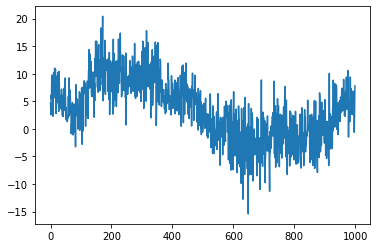

In [82]:

y_t, x_t, w_t, beta_x, beta_w = gen_data_for_model1()
plt.plot(y_t)

In [93]:
mod = TVRegression(y_t, x_t, w_t)
res_mle = mod.fit(disp=False)
print(res_mle.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                 1000
Model:                   TVRegression   Log Likelihood               -2336.846
Date:                Fri, 01 May 2020   AIC                           4685.692
Time:                        11:11:22   BIC                           4715.139
Sample:                             0   HQIC                          4696.884
                               - 1000                                         
Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept       5.0548      0.202     25.050      0.000       4.659       5.450
var.e           5.1240      0.249     20.571      0.000       4.636       5.612
var.x.coeff     0.0468      0.022      2.097    

### Bayesian estimation

We need to define a prior for each parameter and the number of draws and burn-in points

In [100]:
# Set sampling params
ndraws = 3000  #  3000 number of draws from the distribution
nburn = 600   # 600 number of "burn-in points" (which will be discarded)

In [101]:
# Construct an instance of the Theano wrapper defined above, which
# will allow PyMC3 to compute the likelihood and Jacobian in a way
# that it can make use of. Here we are using the same model instance
# created earlier for MLE analysis (we could also create a new model
# instance if we preferred)
loglike = Loglike(mod)

with pm.Model():
    # Priors
    intercept = pm.Uniform('intercept', 1, 10)
    var_e = pm.InverseGamma('var.e', 2.3, 0.5)
    var_x_coeff = pm.InverseGamma('var.x.coeff', 2.3, 0.1)
    var_w_coeff = pm.InverseGamma('var.w.coeff', 2.3, 0.1)

    # convert variables to tensor vectors
    theta = tt.as_tensor_variable([intercept, var_e, var_x_coeff, var_w_coeff])

    # use a DensityDist (use a lamdba function to "call" the Op)
    pm.DensityDist('likelihood', lambda v: loglike(v), observed={'v': theta})

    # Draw samples
    trace = pm.sample(ndraws, tune=nburn, discard_tuned_samples=True, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [var.w.coeff, var.x.coeff, var.e, intercept]
Sampling 4 chains, 0 divergences: 100%|██████████| 14400/14400 [03:22<00:00, 71.19draws/s]


### How does the posterior distribution compare with the MLE estimation?

The clearly peak around the MLE estimate.

<Figure size 432x288 with 0 Axes>

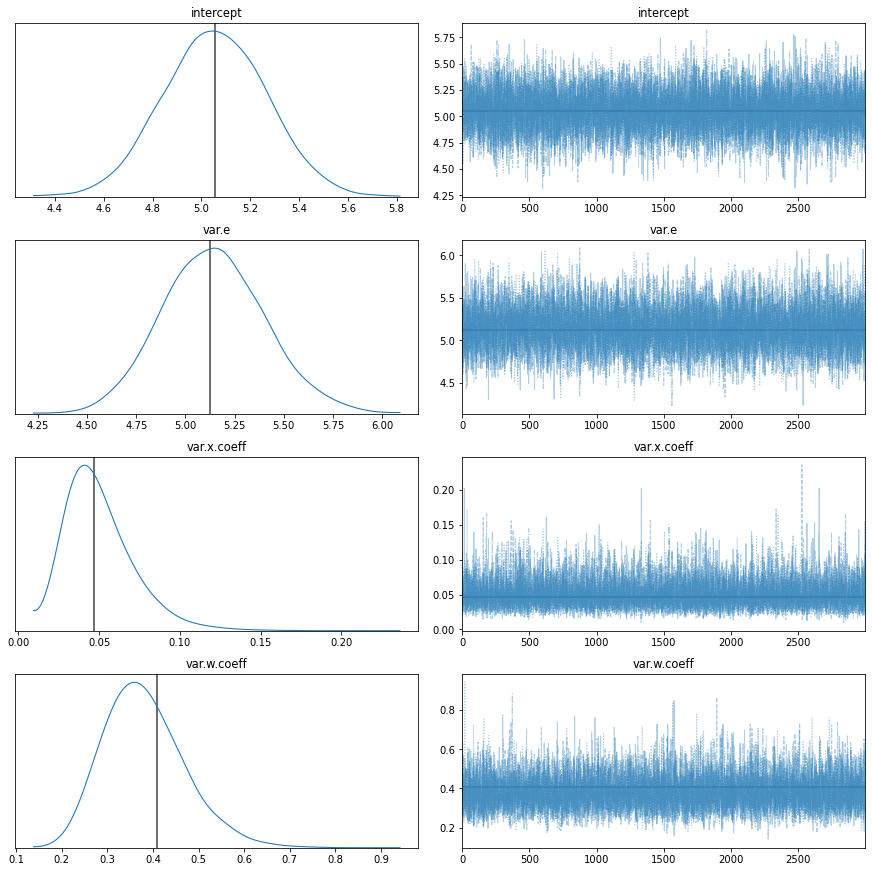

In [102]:

results_dict = {'intercept': res_mle.params[0], 'var.e': res_mle.params[1],
                'var.x.coeff': res_mle.params[2], 'var.w.coeff': res_mle.params[3]}
plt.tight_layout()
_ = pm.traceplot(trace,
                 lines=[(k, {}, [v]) for k, v in dict(results_dict).items()],
                 combined=True,
                 figsize=(12, 12))

